In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import h5py
import os
import pickle
file_dir = os.getcwd()

In [2]:
# 读取 hdf5 文件中的动作数据
def read_libero_data(file_path):
    with h5py.File(file_path, 'r') as f:
        actions = f['action'][()][:, 0:7]  # 只取前7维
    actions = torch.from_numpy(actions)  # 转为 torch 张量
    return actions

def read_rlbench_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data["high_freq_joint_positions"]


In [3]:
# 绘制动作的频谱图和时域图
def plot_action_spectrum(actions: torch.Tensor, sample_rate=1.0, lowpass_cutoff=None, max_freq=None):
    assert actions.ndim == 2, "actions 必须是 (length, action_dim) 形状"
    length, action_dim = actions.shape
    actions_np = actions.cpu().numpy()  # 转为 numpy 数组

    freqs = np.fft.fftfreq(length, d=1 / sample_rate)  # 计算频率轴
    pos_mask = freqs >= 0  # 只保留正频率部分
    freqs = freqs[pos_mask]

    # 创建子图，每个动作维度两列（时域+频谱）
    fig, axs = plt.subplots(action_dim, 2, figsize=(12, 3.5 * action_dim), sharex=False)

    if action_dim == 1:
        axs = [axs]  # 保证 axs 可迭代

    time_axis = np.linspace(0, length / sample_rate, num=length)  # 生成时间轴

    for i in range(action_dim):
        signal = actions_np[:, i]  # 取第 i 个动作维度

        # 如果设置了低通滤波，则先滤波
        if lowpass_cutoff is not None and lowpass_cutoff < sample_rate / 2:
            sos = scipy.signal.butter(N=4, Wn=lowpass_cutoff, fs=sample_rate, btype='low', output='sos')
            signal = scipy.signal.sosfilt(sos, signal)

        fft_vals = np.fft.fft(signal)  # 傅里叶变换
        magnitude = np.abs(fft_vals)[pos_mask]  # 取幅值，只保留正频率

        peak_idx = np.argmax(magnitude[1:]) + 1  # 找到主峰（跳过直流分量）
        peak_freq = freqs[peak_idx]
        peak_mag = magnitude[peak_idx]

        # 绘制时域图
        axs[i, 0].plot(time_axis, signal, color='darkgreen', lw=2)
        axs[i, 0].set_title(f"Action Dimension {i} - Time Domain", fontsize=9)
        axs[i, 0].set_ylabel("Amplitude", fontsize=9)
        axs[i, 0].set_xlabel("Time (s)", fontsize=9)
        axs[i, 0].set_xlim(time_axis[0], time_axis[-1])
        axs[i, 0].grid(True, linestyle='--', alpha=0.5)
        axs[i, 0].tick_params(axis='both', labelsize=6)

        # 绘制频谱图
        axs[i, 1].plot(freqs, magnitude, color='steelblue', lw=2)
        axs[i, 1].scatter([peak_freq], [peak_mag], color='crimson', label=f'Peak: {peak_freq:.2f} Hz')
        axs[i, 1].set_title(f"Action Dimension {i} - Frequency Spectrum", fontsize=9)
        axs[i, 1].set_xlabel("Frequency (Hz)", fontsize=9)
        axs[i, 1].set_ylabel("Magnitude", fontsize=9)
        axs[i, 1].legend()
        axs[i, 1].grid(True, linestyle='--', alpha=0.5)
        axs[i, 1].tick_params(axis='both', labelsize=6)

        if max_freq is not None:
            axs[i, 1].set_xlim(0, max_freq)  # 限制最大频率显示范围

    axs[-1, 1].set_xlabel("Frequency (Hz)", fontsize=9)  # 最后一行加 x 轴标签

    fig.subplots_adjust(top=0.95, bottom=0.1, left=0.08, right=0.97, hspace=0.5)  # 调整子图间距
    return fig

# 更新绘图区域
def update_plot(actions, sample_rate, lowpass_cutoff, max_freq):
    for widget in canvas_frame.winfo_children():
        widget.destroy()  # 清空原有图像

    fig = plot_action_spectrum(actions, sample_rate, lowpass_cutoff, max_freq)  # 生成新图
    canvas = FigureCanvasTkAgg(fig, master=canvas_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)


In [4]:
# 主界面函数
def main_ui():
    def on_update_plot():
        # actions = read_libero_data(file_dir + '/data/actions_left_demo1.hdf5')
        actions = read_libero_data(file_dir + '/data/actions_right_demo1.hdf5')
        # actions = read_libero_data('/Users/zeen/study/AR/data/episode_0.hdf5')  # 读取数据
        # actions = torch.randn([400,5])  # 可用于测试
        sample_rate = float(sample_rate_entry.get())
        lowpass_cutoff = float(lowpass_cutoff_entry.get()) if lowpass_cutoff_entry.get() else None
        max_freq = float(desired_max_freq_entry.get()) if desired_max_freq_entry.get() else None
        update_plot(actions, sample_rate, lowpass_cutoff, max_freq)  # 更新图像

    root = tk.Tk()
    root.title("动态频谱图绘制")
    root.geometry("1000x700")

    main_frame = tk.Frame(root)
    main_frame.pack(fill=tk.BOTH, expand=True)

    control_frame = tk.Frame(main_frame)
    control_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=10)

    global canvas_frame
    canvas_frame = tk.Frame(main_frame, pady=10)
    canvas_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

    # 控件：采样率
    tk.Label(control_frame, text="Sample Rate (Hz)").grid(row=0, column=0, padx=5, pady=5)
    sample_rate_entry = tk.Entry(control_frame)
    sample_rate_entry.grid(row=0, column=1, padx=5, pady=5)
    sample_rate_entry.insert(0, "50")

    # 控件：低通滤波截止频率
    tk.Label(control_frame, text="Lowpass Cutoff (Hz)").grid(row=0, column=2, padx=5, pady=5)
    lowpass_cutoff_entry = tk.Entry(control_frame)
    lowpass_cutoff_entry.grid(row=0, column=3, padx=5, pady=5)
    lowpass_cutoff_entry.insert(0, "25")

    # 控件：最大频率显示
    tk.Label(control_frame, text="Max Frequency (Hz)").grid(row=0, column=4, padx=5, pady=5)
    desired_max_freq_entry = tk.Entry(control_frame)
    desired_max_freq_entry.grid(row=0, column=5, padx=5, pady=5)
    desired_max_freq_entry.insert(0, "25")

    # 确认按钮
    button = tk.Button(control_frame, text="确认", command=on_update_plot)
    button.grid(row=0, column=6, padx=5, pady=5)

    root.mainloop()

In [6]:
# run interactive window
# main_ui()
# action from aloha env: ["waist", "s", "elbow", "forearm_roll", "wrist_angle", "wrist_rotate"]

In [7]:
print(np.linspace(0,4/10,5))

[0.  0.1 0.2 0.3 0.4]


In [5]:
def plot_action_static_with_spectrum(actions: torch.Tensor, sample_rate=1.0, max_freq=None, plot_reconstructed: bool = False):
    """
    绘制动作信号的静态时域图和频谱图

    参数:
        actions: torch.Tensor, 形状为 (length, action_dim)
        sample_rate: 采样率 (Hz)
        max_freq: 频谱图最大显示频率 (Hz)，可选
    """
    assert actions.ndim == 2, "actions 必须是 (length, action_dim) 形状"
    length, action_dim = actions.shape
    actions_np = actions.cpu().numpy()
    time_axis = np.linspace(0, length / sample_rate, num=length)
    freqs = np.fft.fftfreq(length, d=1 / sample_rate) # calculate frequency axis
    print(f"freqs shape:{freqs.shape}, 1st: {freqs[0]}, last: {freqs[-1]}, difference:{np.diff(freqs[0:5])}")
    # freqs: 0,0.125,...,24.875,-25,-24.875,...,-0.125
    pos_mask = freqs >= 0
    freqs = freqs[pos_mask]
    
    num_cols = 3 if plot_reconstructed else 2
    fig_width = 18 if plot_reconstructed else 12

    fig, axs = plt.subplots(action_dim, num_cols, figsize=(fig_width, 3 * action_dim), sharex=False)
    if action_dim == 1:
        axs = [axs]

    for i in range(action_dim):
        
        signal = actions_np[:, i]
        
        # 时域图
        axs[i][0].plot(time_axis, signal, color='royalblue', lw=2)
        axs[i][0].set_ylabel(f"Dim {i}", fontsize=9)
        axs[i][0].set_title(f"Action {i} - Time Domain", fontsize=10)
        axs[i][0].grid(True, linestyle='--', alpha=0.5)
        axs[i][0].tick_params(axis='both', labelsize=8)
        
        # apply Fourier Transform
        fft_vals = np.fft.fft(signal)
        magnitude = np.abs(fft_vals)[pos_mask]/length
        # print(magnitude[-10:])
        # double the non-DC and non-Nyquist components
        if length % 2 == 0: # If N is even, there's a unique Nyquist component (at index N/2)x, and the indices 1 to length//2 - 1 are the non-DC, non-Nyquist positive frequencies
            magnitude[1:-1] *= 2 # Double all except DC and Nyquist
        else: # If N is odd, there's no unique Nyquist component, and all positive frequencies (except DC) are doubled
            magnitude[1:] *= 2 # Double all except DC
                    
        # 频谱图
        axs[i][1].plot(freqs, magnitude, color='darkorange', lw=2) # use pre-computed "freqs" as x-axis
        axs[i][1].set_title(f"Action {i} - Spectrum", fontsize=10)
        axs[i][1].set_ylabel("Magnitude", fontsize=9)
        axs[i][1].grid(True, linestyle='--', alpha=0.5)
        axs[i][1].tick_params(axis='both', labelsize=8)
        if max_freq is not None:
            axs[i][1].set_xlim(0, max_freq)

                # --- Column 3: Reconstructed Signal (Optional) ---
        if plot_reconstructed:
            if length > 0:
                reconstructed_signal_complex = np.fft.ifft(fft_vals)
                reconstructed_signal = np.real(reconstructed_signal_complex) # Should be real
                
                # Optional: Check reconstruction error
                # if not np.allclose(signal, reconstructed_signal):
                #    print(f"Dim {i}: Max reconstruction error: {np.max(np.abs(signal - reconstructed_signal))}")

                axs[i, 2].plot(time_axis, reconstructed_signal, color='mediumseagreen', lw=1.5, linestyle='--')
            else: # Handle empty signal case for plot
                 axs[i, 2].plot([], [], color='mediumseagreen', lw=1.5, linestyle='--')

            axs[i, 2].set_title(f"Action {i} - IFFT Reconstructed", fontsize=10)
            axs[i, 2].grid(True, linestyle='--', alpha=0.5)
            axs[i, 2].tick_params(axis='both', labelsize=8)
            
    axs[-1][0].set_xlabel("Time (s)", fontsize=10)
    axs[-1][1].set_xlabel("Frequency (Hz)", fontsize=10)
    if plot_reconstructed:
        axs[-1, 2].set_xlabel("Time (s)", fontsize=10)
    fig.suptitle("Action Signal: Time Domain & Spectrum", fontsize=13)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

In [6]:
actions = read_libero_data(file_dir + '/data/actions_right_demo1.hdf5')
print(f"action shape: {actions.shape}")
# print(f"actions: {actions}")

action shape: torch.Size([400, 7])


freqs shape:(400,), 1st: 0.0, last: -0.125, difference:[0.125 0.125 0.125 0.125]


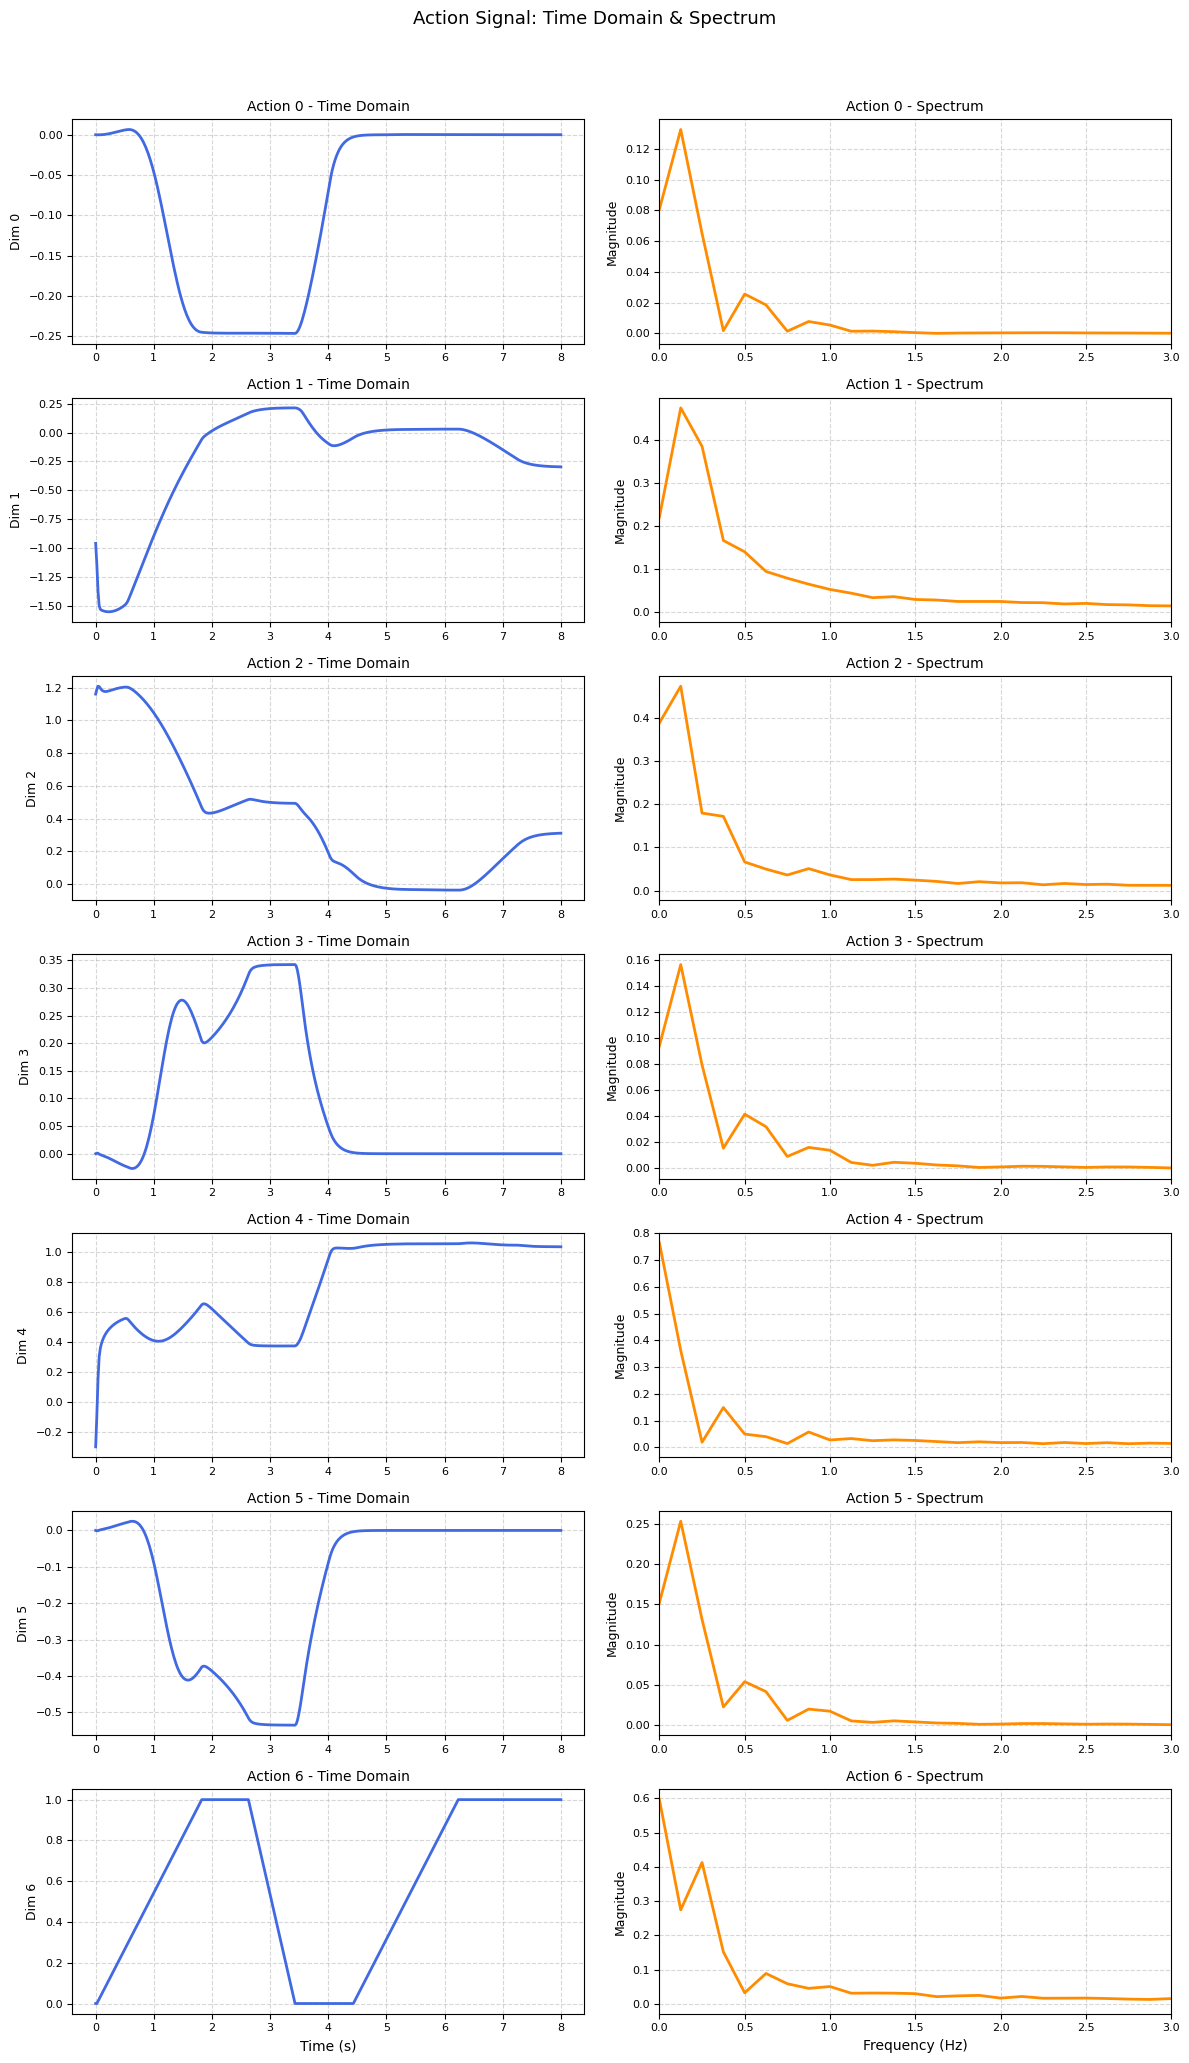

In [ ]:
# libero right demo1, FFT spectrum
actions = read_libero_data(file_dir + '/data/actions_right_demo1.hdf5')
fig = plot_action_static_with_spectrum(actions, sample_rate=50, max_freq=3, plot_reconstructed=False)
plt.show(fig)

freqs shape:(400,), 1st: 0.0, last: -0.125, difference:[0.125 0.125 0.125 0.125]


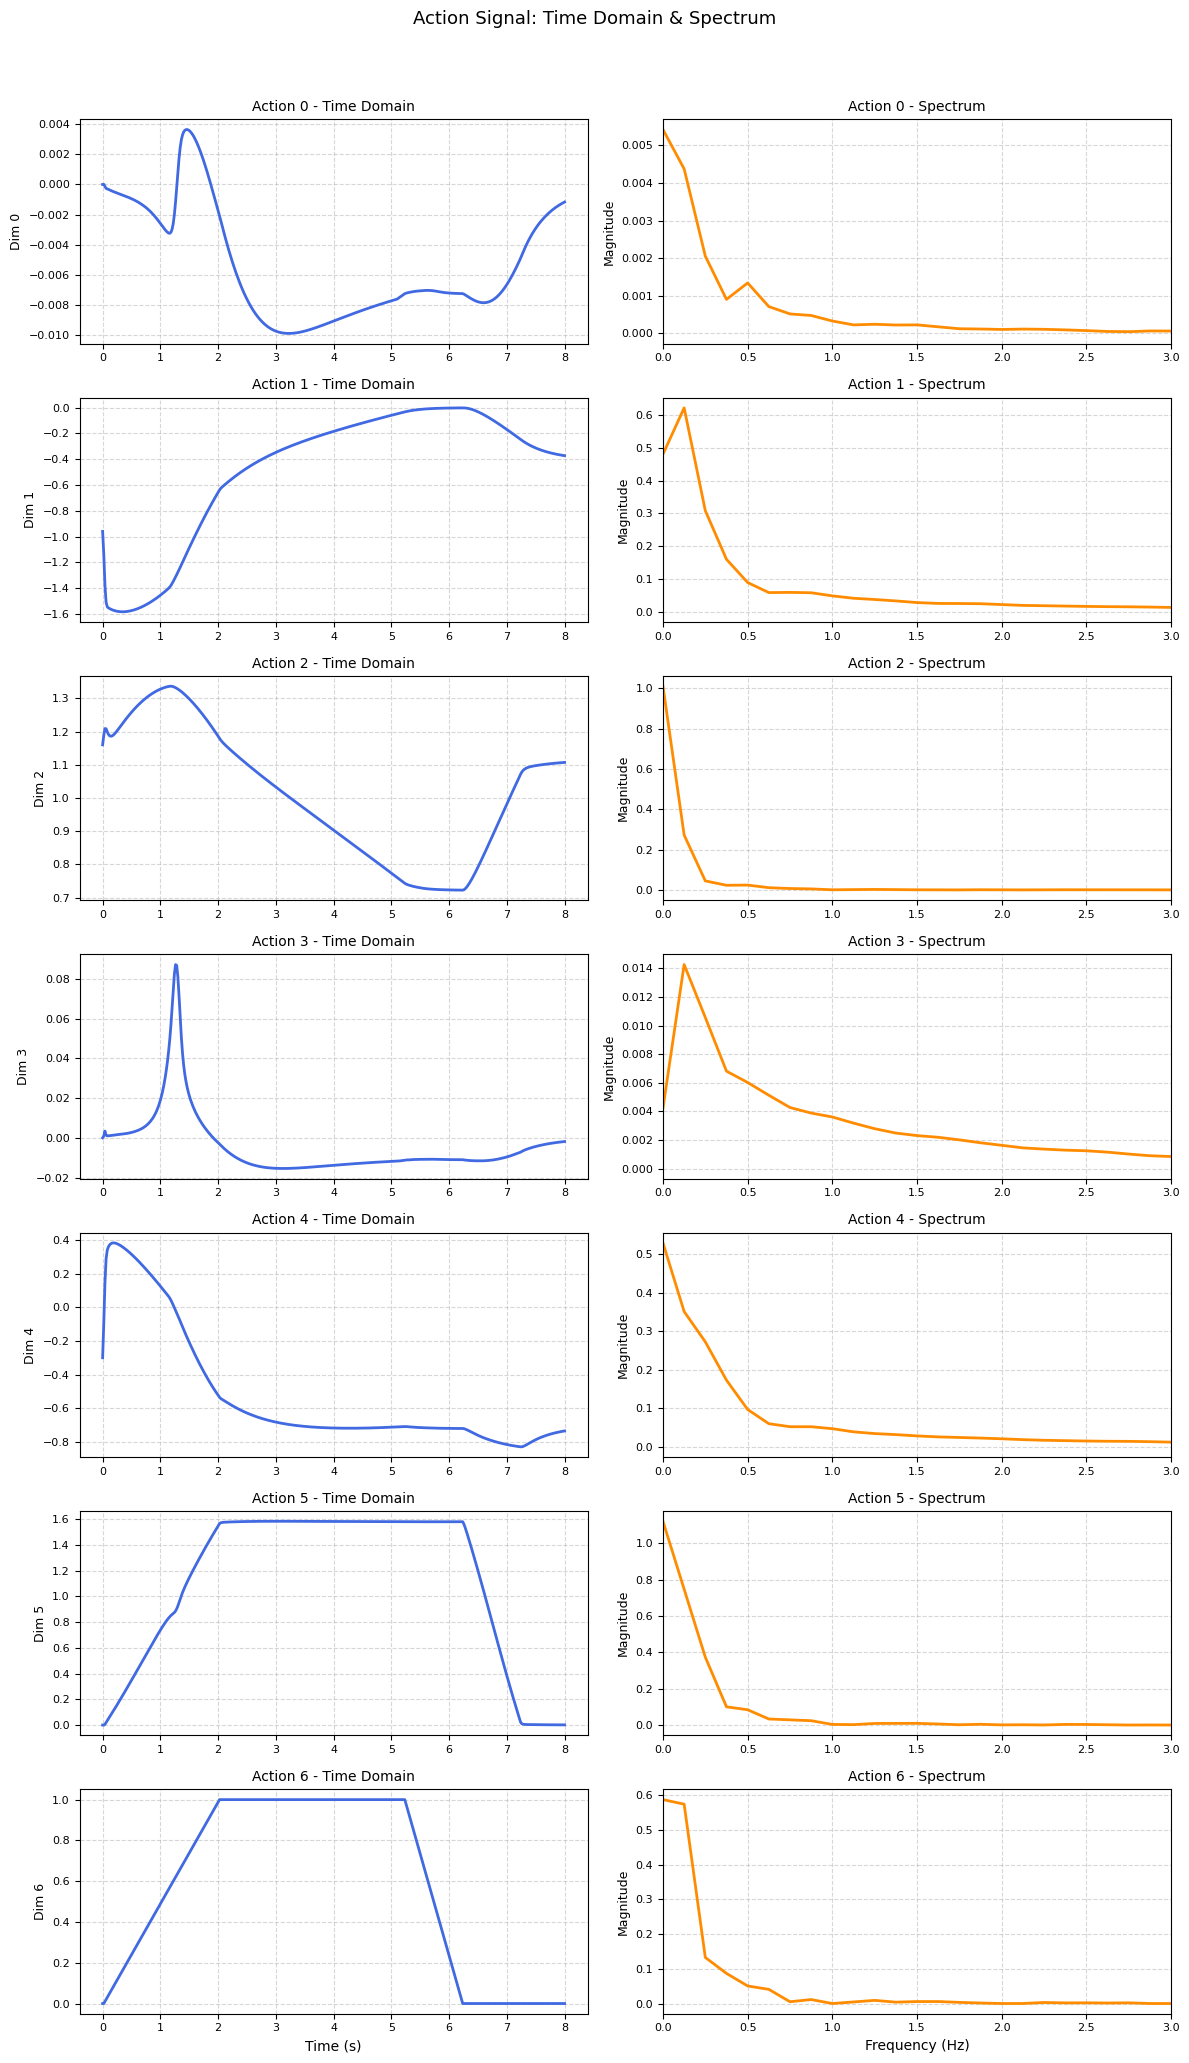

In [ ]:
# libero left demo1, FFT spectrum
actions = read_libero_data(file_dir + '/data/actions_left_demo1.hdf5')
fig = plot_action_static_with_spectrum(actions, sample_rate=50, max_freq=3)
plt.show()

In [21]:
# rlbench data
# actions = read_rlbench_data(file_dir + '/data/rlbench/high_freq_joint_positions.h5')
actions = read_rlbench_data(file_dir + '/data/rlbench/high_freq_joint_positions.h5')
print("Read rlbench data")
actions=actions[0]
fig = plot_action_static_with_spectrum(actions, sample_rate=50, max_freq=3)
plt.show()

UnpicklingError: invalid load key, 'H'.

In [22]:
def dct(x, norm='ortho'):
    """
    Discrete Cosine Transform, Type II (DCT-II)
    
    Args:
        x: the input signal
        norm: normalization mode
        
    Return:
        the DCT-II of the signal over the last dimension
    """
    if not hasattr(torch, 'functional') or not hasattr(torch.functional, 'dct'):
        # print(f"Using custom DCT function")
        # 如果torch没有内置DCT函数，使用自定义实现
        x_shape = x.shape
        N = x_shape[-1] # 信号长度
        
        # 创建DCT-II变换矩阵
        k = torch.arange(N, dtype=x.dtype, device=x.device).unsqueeze(1) # [N, 1]
        n = torch.arange(N, dtype=x.dtype, device=x.device).unsqueeze(0) # [1, N]
        
        dct_mat = torch.cos(torch.pi * (2*n + 1) * k / (2*N)) # [N, N]
        
        # 第一行需要特殊处理
        if norm == 'ortho':
            dct_mat[0] *= torch.sqrt(torch.tensor(1.0/N, device=x.device))
            dct_mat[1:] *= torch.sqrt(torch.tensor(2.0/N, device=x.device))
        
        # 应用DCT-II变换，[N, N] * [N, 1] = [N, 1]
        result = torch.matmul(dct_mat, x.unsqueeze(-1)).squeeze(-1)
        return result
    else:
        # 使用PyTorch内置的DCT函数
        print(f"Using PyTorch builtin DCT function")
        return torch.functional.dct(x, norm=norm)

def idct(x, norm='ortho'):
    """
    Inverse Discrete Cosine Transform, Type II (DCT-III)
    
    Args:
        x: the input spectrum
        norm: normalization mode
        
    Return:
        the inverse DCT-II of the spectrum over the last dimension
    """
    if not hasattr(torch, 'functional') or not hasattr(torch.functional, 'idct'):
        # 如果torch没有内置IDCT函数，使用自定义实现
        x_shape = x.shape
        N = x_shape[-1]
        
        # 创建DCT-III变换矩阵
        n = torch.arange(N, dtype=x.dtype, device=x.device).unsqueeze(1) # [N, 1]
        k = torch.arange(N, dtype=x.dtype, device=x.device).unsqueeze(0) # [1, N]
        
        idct_mat = torch.cos(torch.pi * k * (2*n + 1) / (2*N)) # [N, N]
        
        # 第一列需要特殊处理
        if norm == 'ortho':
            idct_mat[:, 0] *= torch.sqrt(torch.tensor(1.0/N, device=x.device))
            idct_mat[:, 1:] *= torch.sqrt(torch.tensor(2.0/N, device=x.device))
        else:
            idct_mat[:, 0] *= 0.5
        
        # 应用DCT-III变换，[N, N] * [N, 1] = [N, 1]
        result = torch.matmul(idct_mat, x.unsqueeze(-1)).squeeze(-1)
        
        if norm != 'ortho':
            result *= (2.0/N)
            
        return result
    else:
        # 使用PyTorch内置的IDCT函数
        return torch.functional.idct(x, norm=norm)


In [41]:
def plot_action_static_with_spectrum_dct_fixed(actions: torch.Tensor, sample_rate=1.0, max_freq=None, plot_reconstructed: bool = False):
    """
    绘制动作信号的静态时域图和DCT频谱图（修复版本）

    参数:
        actions: torch.Tensor, 形状为 (length, action_dim)
        sample_rate: 采样率 (Hz)
        max_freq: 频谱图最大显示频率 (Hz)，可选
        plot_reconstructed: 是否显示重建信号，可选
    """
    assert actions.ndim == 2, "actions 必须是 (length, action_dim) 形状"
    length, action_dim = actions.shape
    actions_np = actions.cpu().numpy()
    time_axis = np.linspace(0, length / sample_rate, num=length)
    
    # DCT频率轴（与FFT不同）
    # DCT-II的频率是：f_k = k/(2N) * sample_rate，其中k=0,1,...,N-1
    freqs = np.arange(length) * (sample_rate / (2 * length))
    print(f"DCT freqs shape:{freqs.shape}, 1st: {freqs[0]}, last: {freqs[-1]}")
    
    num_cols = 3 if plot_reconstructed else 2
    fig_width = 18 if plot_reconstructed else 12

    # 创建图表
    fig = plt.figure(figsize=(fig_width, 3 * action_dim))
    
    # 手动创建子图而不是使用subplots，这样可以更好地控制索引方式
    axs = []
    for i in range(action_dim):
        row_axs = []
        for j in range(num_cols):
            ax = fig.add_subplot(action_dim, num_cols, i*num_cols + j + 1)
            row_axs.append(ax)
        axs.append(row_axs)
    
    for i in range(action_dim):
        signal = actions_np[:, i]
        
        # 时域图
        axs[i][0].plot(time_axis, signal, color='royalblue', lw=2)
        axs[i][0].set_ylabel(f"Dim {i}", fontsize=9)
        axs[i][0].set_title(f"Action {i} - Time Domain", fontsize=10)
        axs[i][0].grid(True, linestyle='--', alpha=0.5)
        axs[i][0].tick_params(axis='both', labelsize=8)
        
        try:
            # 应用离散余弦变换 (DCT)
            signal_tensor = torch.from_numpy(signal).float()
            dct_vals = dct(signal_tensor, norm='ortho')
            dct_magnitude = np.abs(dct_vals.numpy())
            
            # 频谱图
            axs[i][1].plot(freqs, dct_magnitude, color='darkred', lw=2)
            axs[i][1].set_title(f"Action {i} - DCT Spectrum", fontsize=10)
            axs[i][1].set_ylabel("Magnitude", fontsize=9)
            axs[i][1].grid(True, linestyle='--', alpha=0.5)
            axs[i][1].tick_params(axis='both', labelsize=8)
            
            if max_freq is not None:
                axs[i][1].set_xlim(0, max_freq)
        except Exception as e:
            print(f"计算DCT时出错: {str(e)}")
            continue
            
        # 重建信号（可选）
        if plot_reconstructed:
            try:
                reconstructed_signal = idct(dct_vals, norm='ortho').numpy()
                
                axs[i][2].plot(time_axis, reconstructed_signal, color='mediumseagreen', lw=1.5, linestyle='--')
                axs[i][2].set_title(f"Action {i} - IDCT Reconstructed", fontsize=10)
                axs[i][2].grid(True, linestyle='--', alpha=0.5)
                axs[i][2].tick_params(axis='both', labelsize=8)
            except Exception as e:
                print(f"重建信号时出错: {str(e)}")
                continue
    
    # 设置最后一行的x轴标签
    for j in range(num_cols):
        axs[-1][j].set_xlabel("Time (s)" if j != 1 else "Frequency (Hz)", fontsize=10)
        
    fig.suptitle("Action Signal: Time Domain & DCT Spectrum", fontsize=13)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

torch.Size([400, 7])
DCT freqs shape:(400,), 1st: 0.0, last: 24.9375


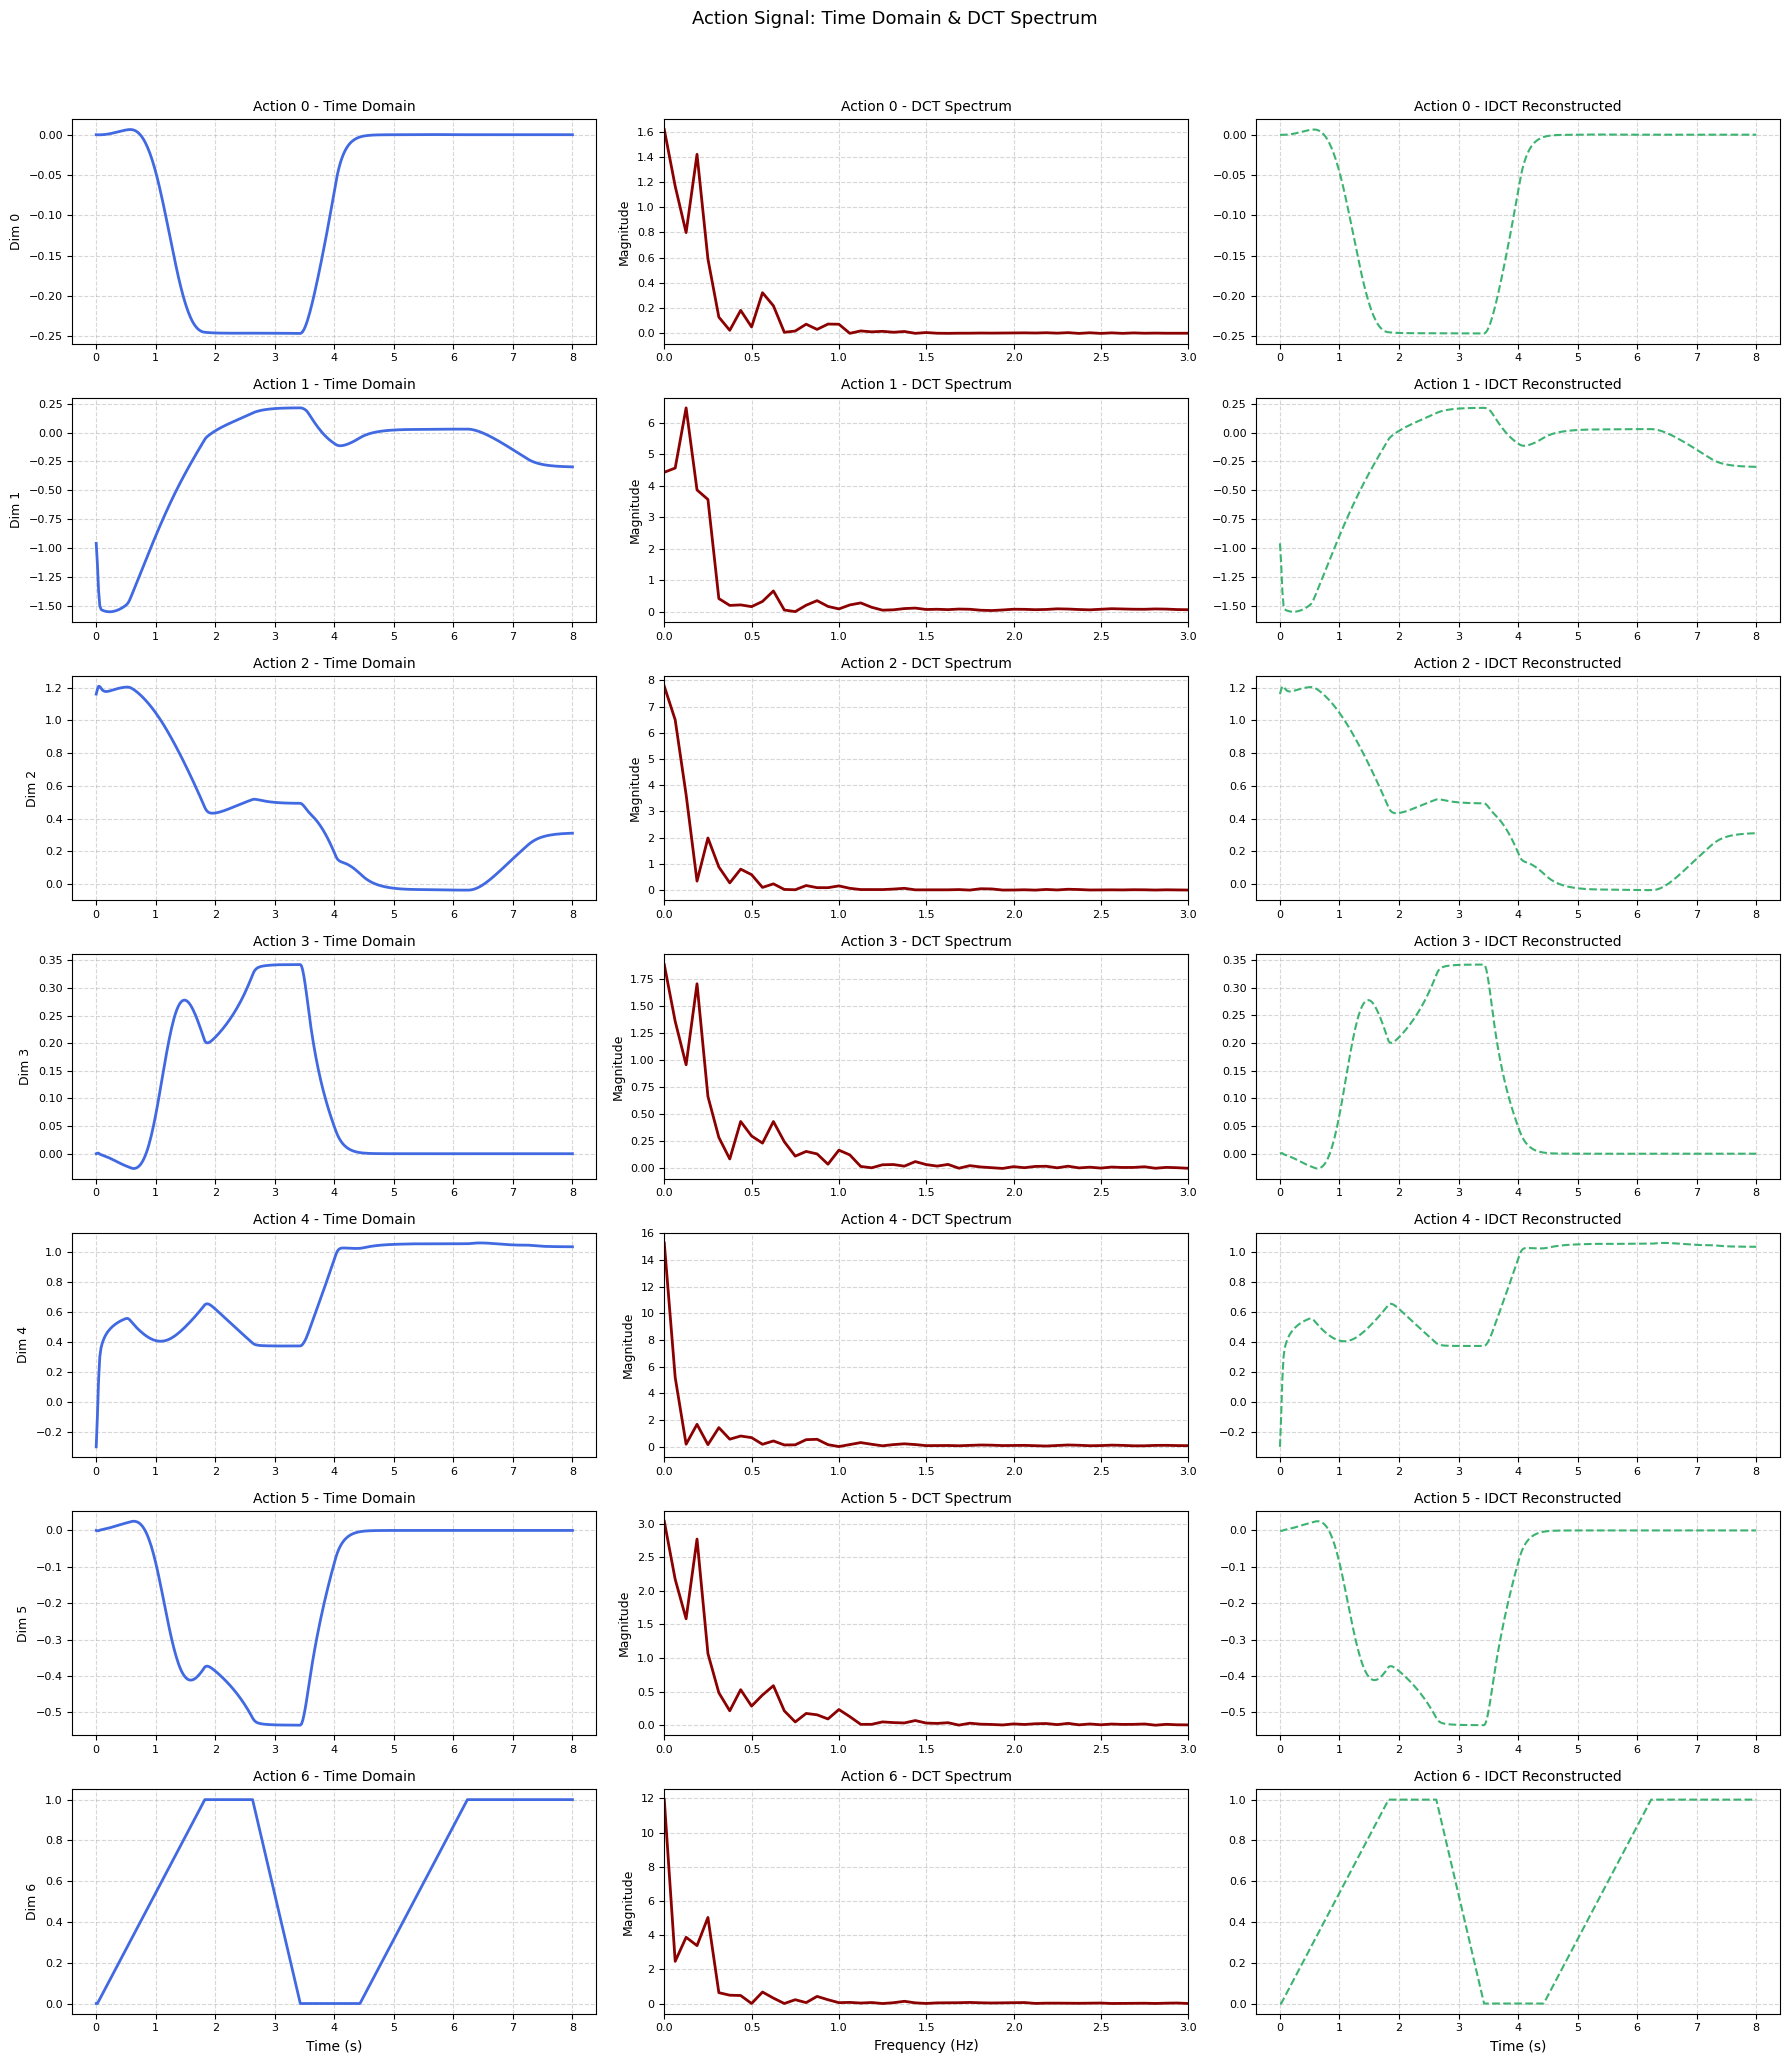

In [43]:

# 测试DCT版本的函数
actions = read_libero_data(file_dir + '/data/actions_right_demo1.hdf5')
print(actions.shape)
fig = plot_action_static_with_spectrum_dct_fixed(actions, sample_rate=50, max_freq=3, plot_reconstructed=True)
plt.show()


In [44]:
# 对比FFT和DCT频谱的区别
def compare_all_joints_in_one_figure(actions, sample_rate=50, max_freq=3):
    """将所有关节的FFT和DCT结果显示在一个大图表中
    布局: 左列=原始信号, 中列=FFT频谱, 右列=DCT频谱
    每行代表一个关节
    """
    _, action_dim = actions.shape
    actions_np = actions.cpu().numpy()
    
    # 创建大图表
    fig, axs = plt.subplots(action_dim, 3, figsize=(20, 3.5*action_dim))
    
    # 创建时间和频率轴
    length = actions.shape[0]
    time_axis = np.linspace(0, length / sample_rate, num=length)
    freqs_fft = np.fft.fftfreq(length, d=1 / sample_rate)
    pos_mask = freqs_fft >= 0
    freqs_fft = freqs_fft[pos_mask]
    freqs_dct = np.arange(length) * (sample_rate / (2 * length))
    
    for i in range(action_dim):
        signal = actions_np[:, i]
        
        # 左列: 原始信号
        axs[i, 0].plot(time_axis, signal, color='royalblue', lw=2)
        axs[i, 0].set_title(f"Joint {i} - Time Domain", fontsize=10)
        axs[i, 0].set_ylabel(f"Joint {i}", fontsize=9)
        axs[i, 0].grid(True, linestyle='--', alpha=0.5)
        axs[i, 0].tick_params(axis='both', labelsize=8)
        
        # 中列: FFT频谱
        fft_vals = np.fft.fft(signal)
        fft_magnitude = np.abs(fft_vals)[pos_mask]/length
        if length % 2 == 0:
            fft_magnitude[1:-1] *= 2
        else:
            fft_magnitude[1:] *= 2
            
        axs[i, 1].plot(freqs_fft, fft_magnitude, color='darkorange', lw=2)
        axs[i, 1].set_title(f"Joint {i} - FFT Spectrum", fontsize=10)
        axs[i, 1].grid(True, linestyle='--', alpha=0.5)
        axs[i, 1].tick_params(axis='both', labelsize=8)
        
        if max_freq is not None:
            axs[i, 1].set_xlim(0, max_freq)
        
        # 右列: DCT频谱
        signal_tensor = torch.from_numpy(signal).float()
        dct_vals = dct(signal_tensor, norm='ortho')
        dct_magnitude = np.abs(dct_vals.numpy())
        
        axs[i, 2].plot(freqs_dct, dct_magnitude, color='darkred', lw=2)
        axs[i, 2].set_title(f"Joint {i} - DCT Spectrum", fontsize=10)
        axs[i, 2].grid(True, linestyle='--', alpha=0.5)
        axs[i, 2].tick_params(axis='both', labelsize=8)
        
        if max_freq is not None:
            axs[i, 2].set_xlim(0, max_freq)
    
    # 设置最后一行的x轴标签
    axs[-1, 0].set_xlabel("Time (s)", fontsize=10)
    axs[-1, 1].set_xlabel("Frequency (Hz)", fontsize=10)
    axs[-1, 2].set_xlabel("Frequency (Hz)", fontsize=10)
    
    # 对第二列和第三列添加统一的y轴标签
    fig.text(0.07, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=12)
    
    plt.suptitle("Comparison of Time Domain, FFT and DCT for All Joints", fontsize=14)
    plt.tight_layout(rect=[0.03, 0, 1, 0.96])
    return fig


分析 7 个关节的数据


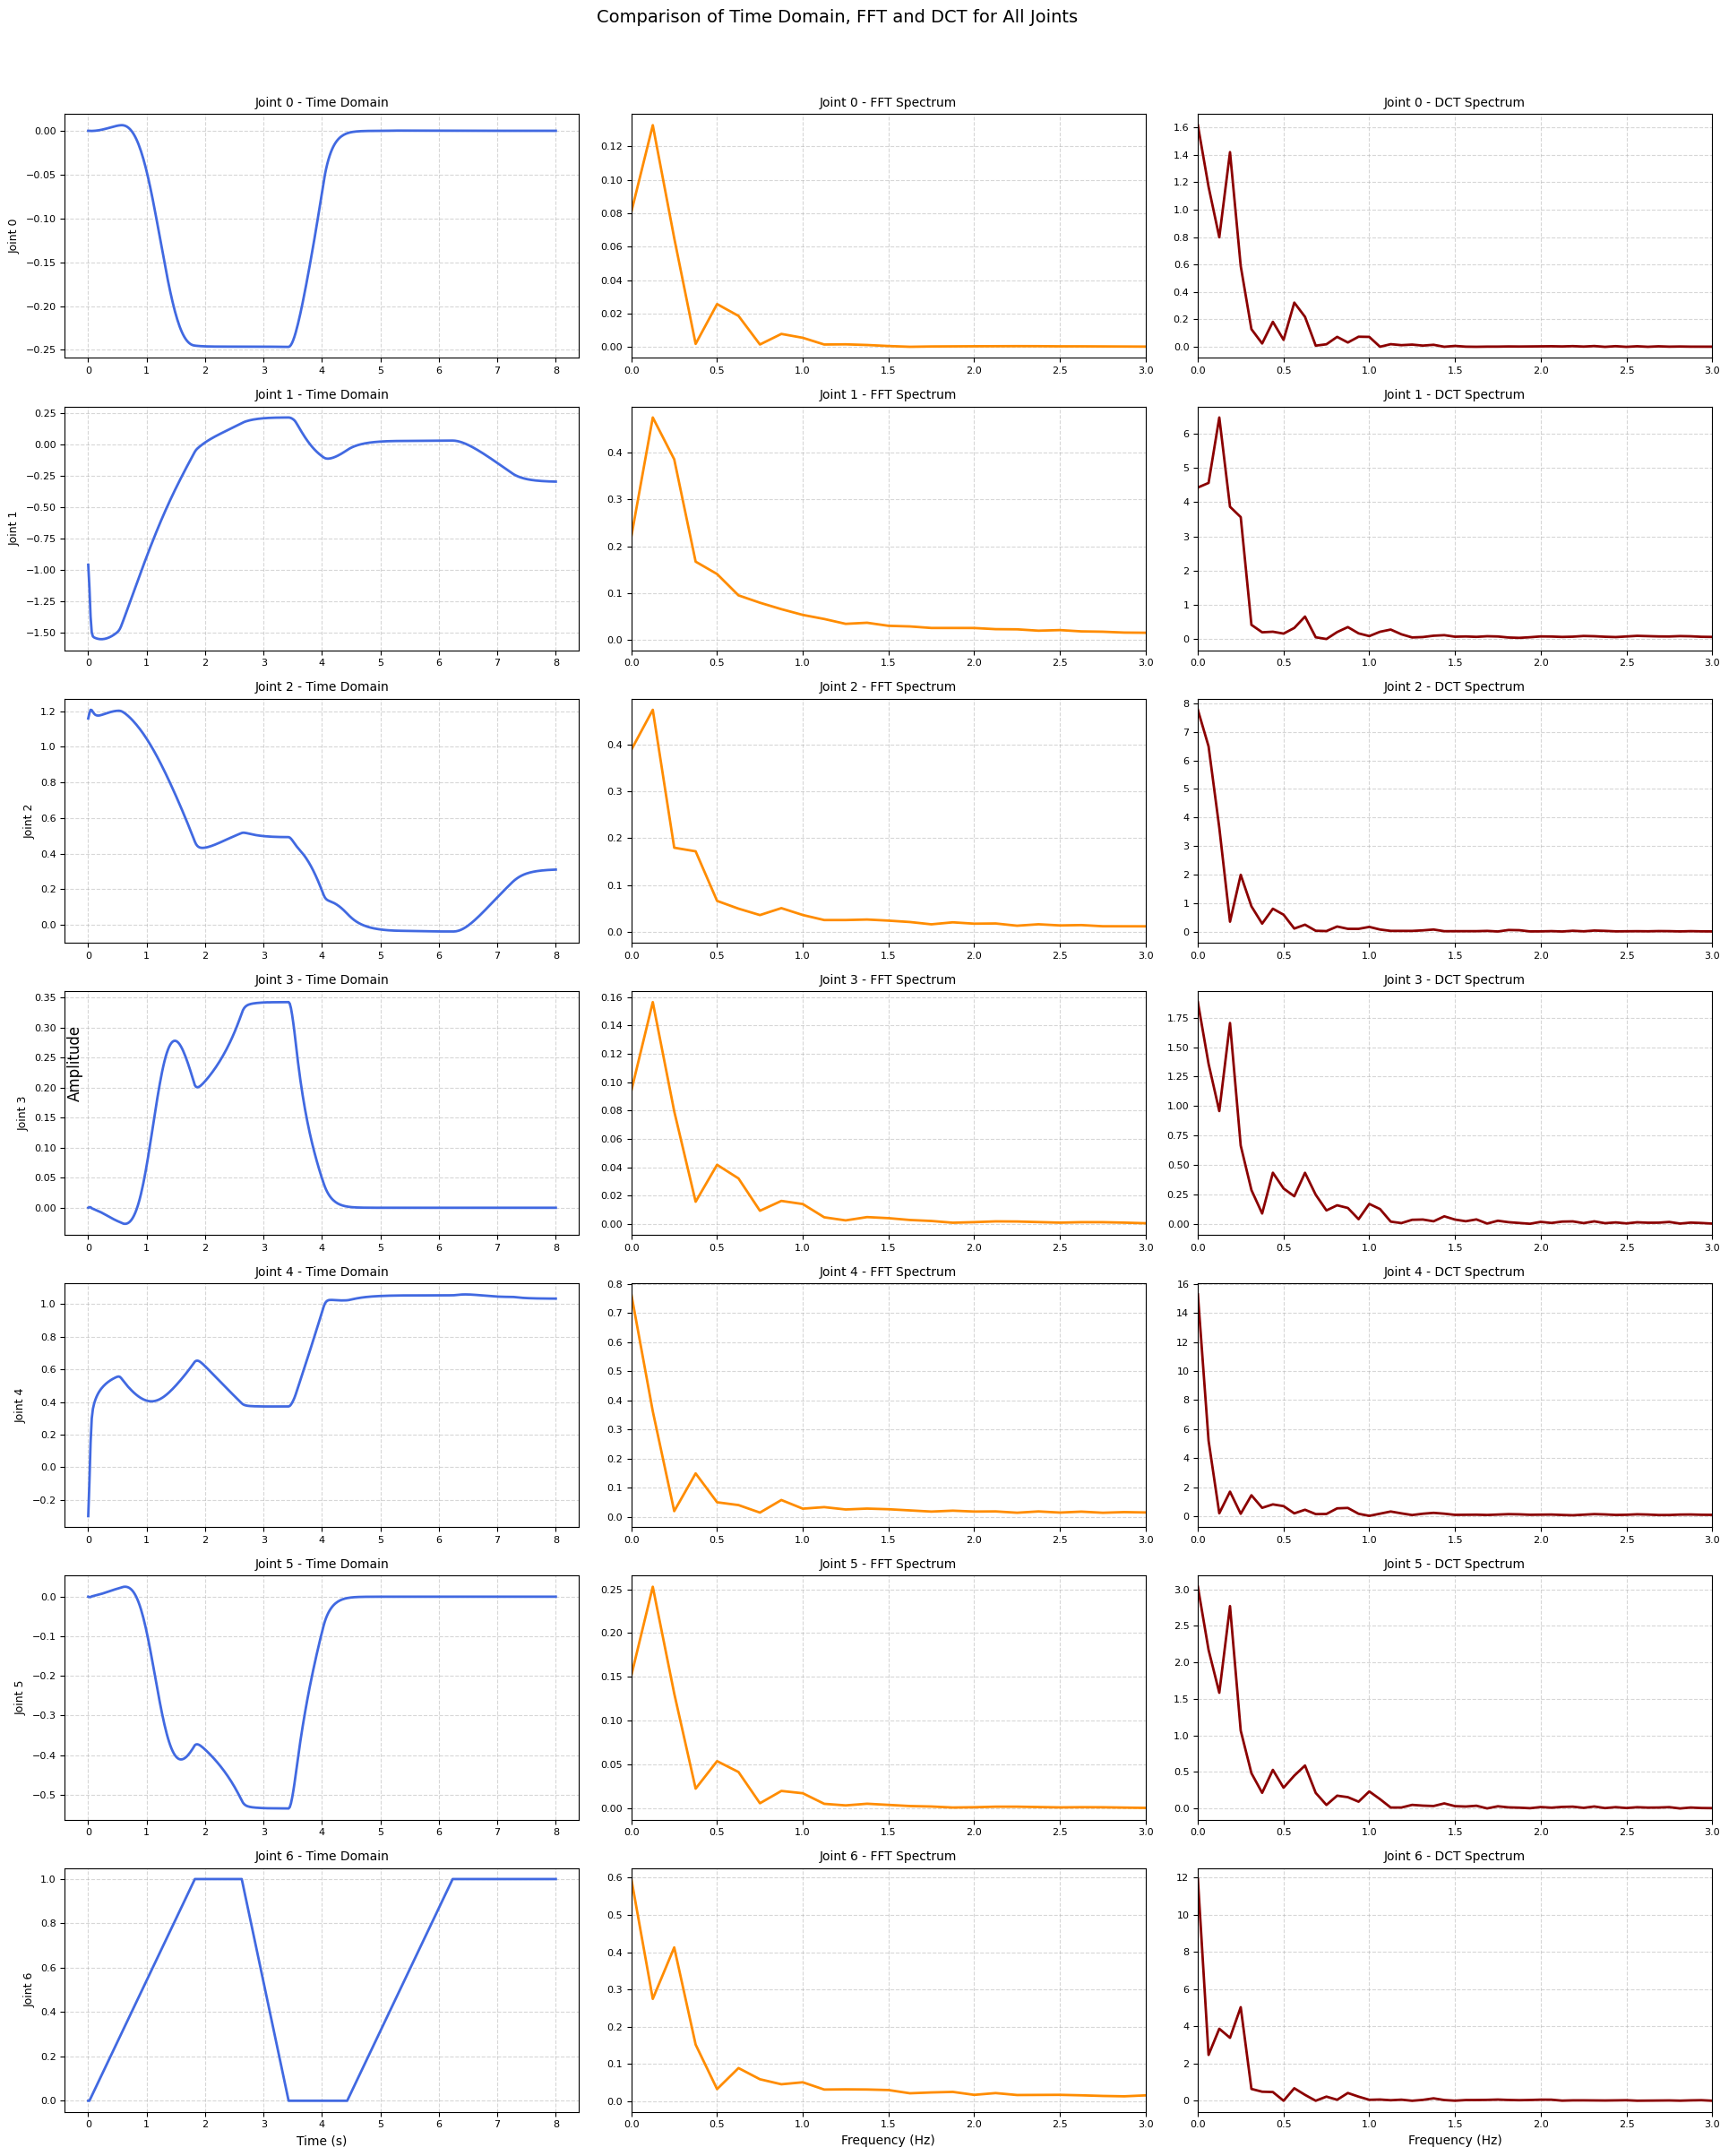

In [32]:
# 对所有关节的数据进行比较，在一个大图表中显示
actions = read_libero_data(file_dir + '/data/actions_right_demo1.hdf5')
print(f"分析 {actions.shape[1]} 个关节的数据")
fig = compare_all_joints_in_one_figure(actions, sample_rate=50, max_freq=3)
plt.show()


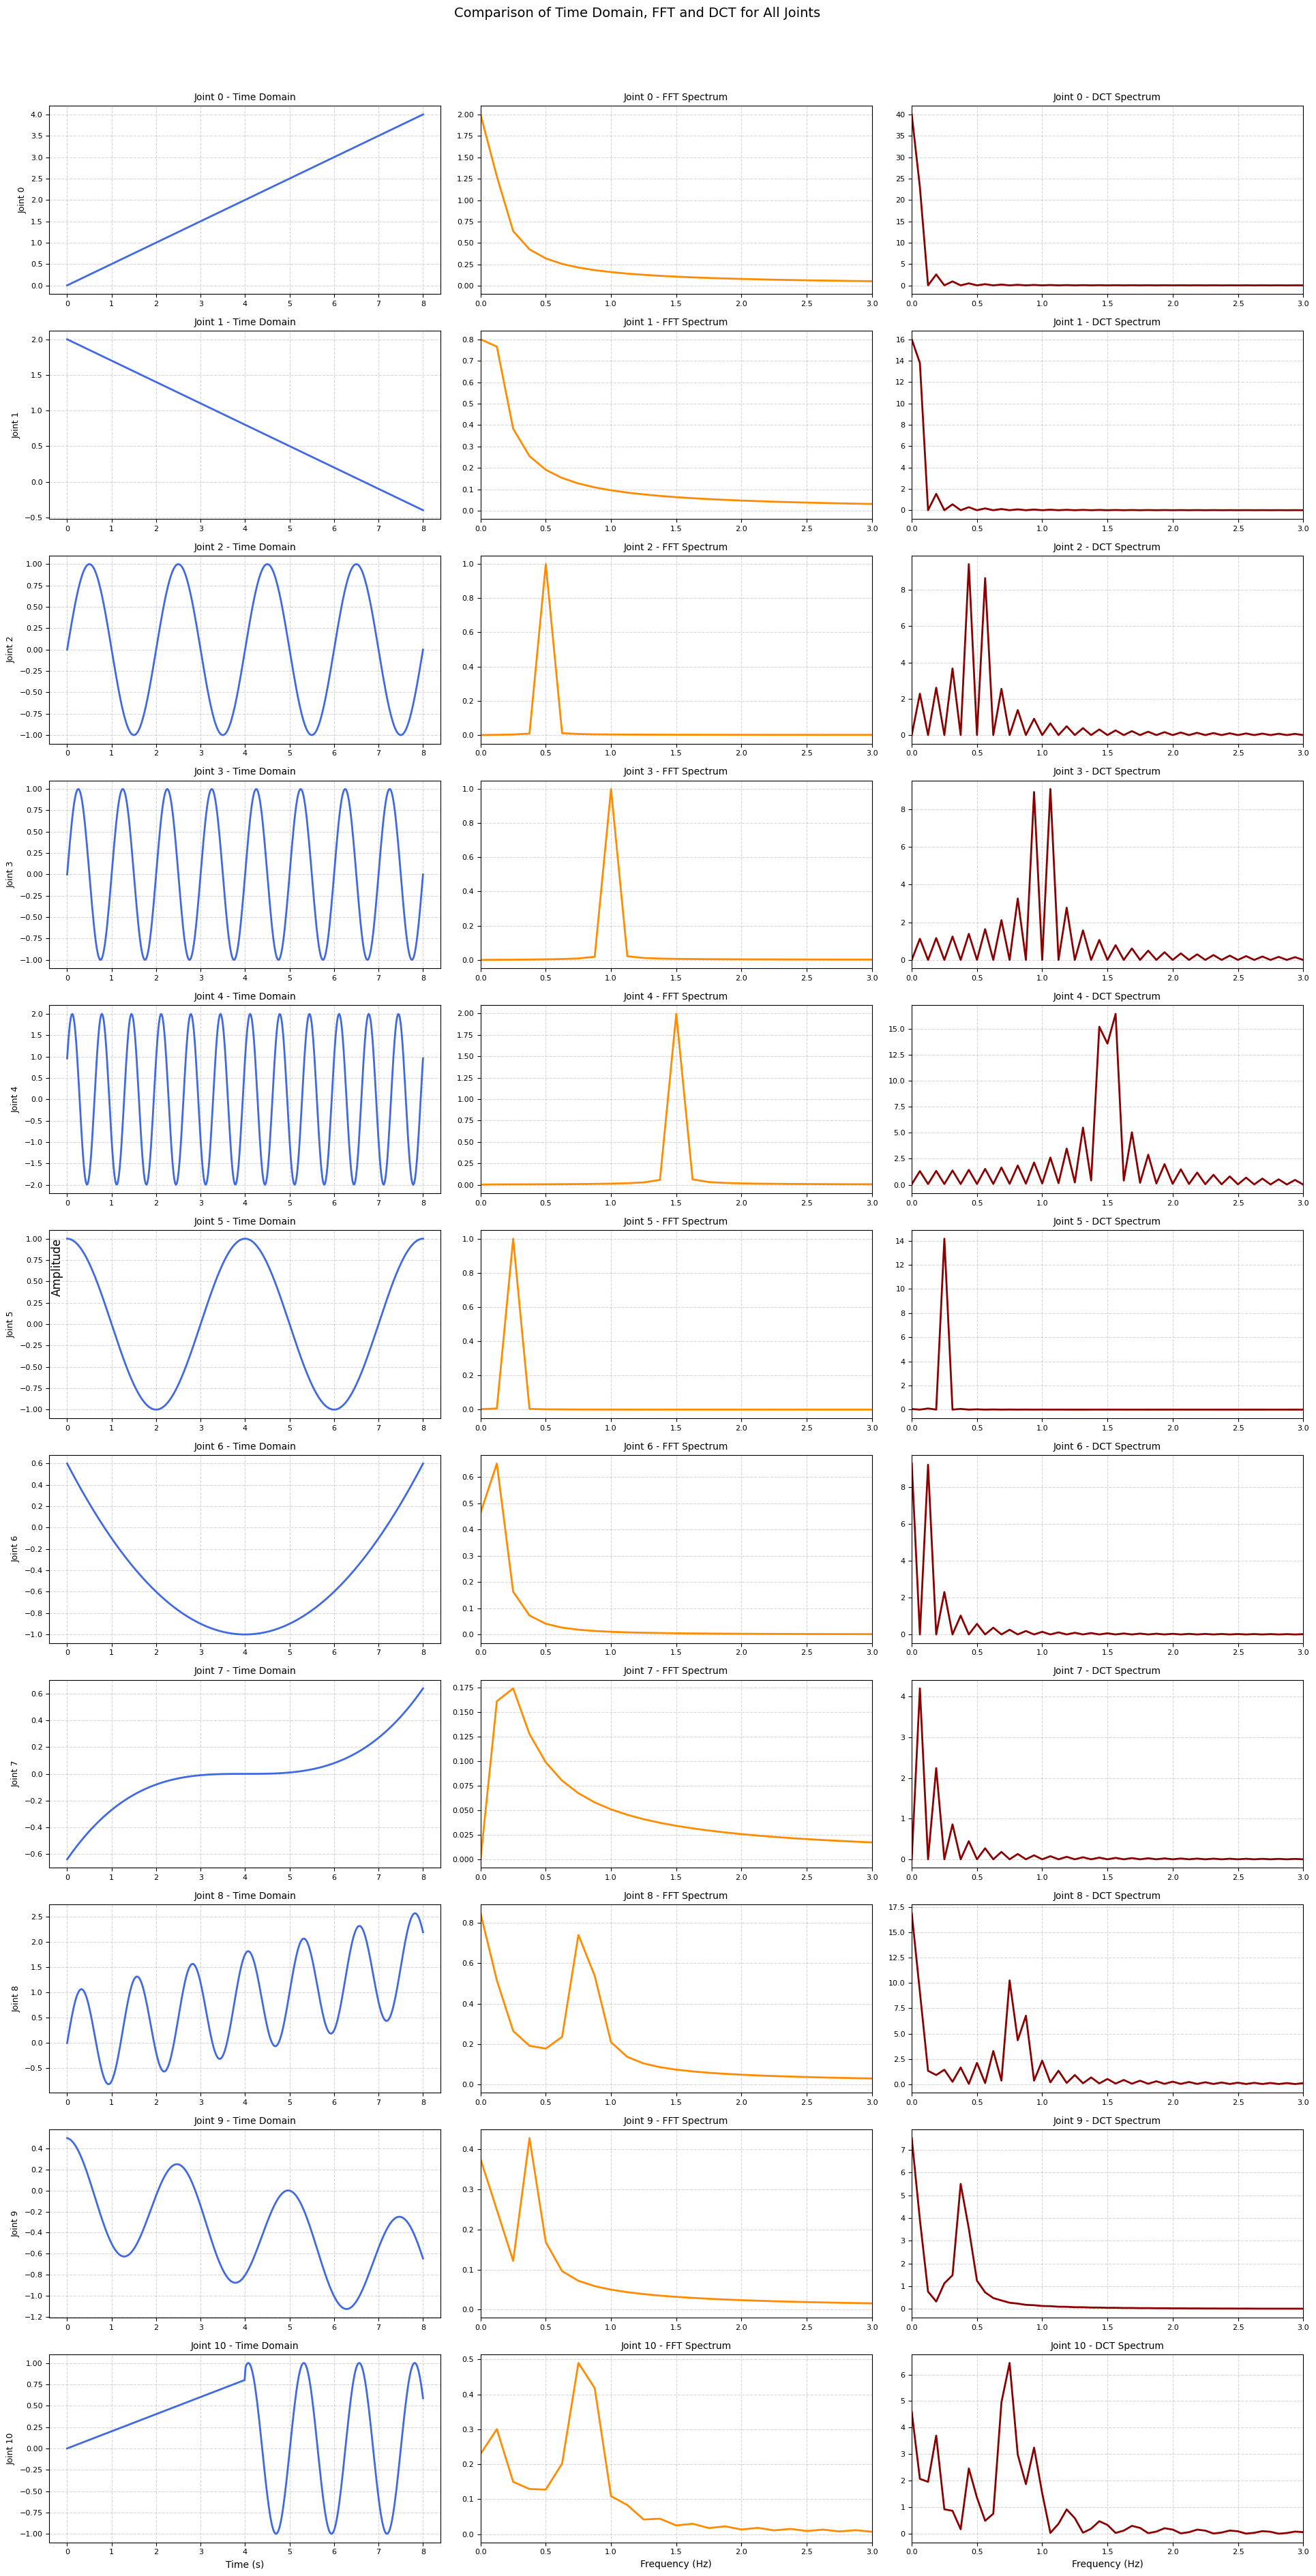

In [50]:
# test FFT and DCT on synthetic data
import torch
import numpy as np
import matplotlib.pyplot as plt

PI = np.pi

# 采样参数
sample_rate = 50  # Hz
duration = 8      # 秒
length = sample_rate * duration
t = np.linspace(0, duration, length)

t1 = np.linspace(0, 4, 200)   # 前4秒
t2 = np.linspace(4, 8, 200)   # 后4秒

# 生成两个不同的信号
sig1 = 0.2 * t1                # 线性
sig2 = np.sin(2 * PI * 0.8 * t2)  # 正弦

action_dict = {
    "linear1": 0.5 * t,           # 斜率0.5
    "linear2": -0.3 * t + 2 ,     # 斜率-0.3，截距2
    "sin1": np.sin(2 * PI * 0.5 * t),           # 0.5Hz 正弦
    "sin2": np.sin(2 * PI * t),               # 1Hz 正弦
    "sin3": 2 * np.sin(2 * PI * 1.5 * t + 0.5), # 1.5Hz 正弦，幅值2
    "cos1": np.cos(2 * PI * 0.25 * t),          # 0.25Hz 余弦
    "quad": 0.1 * (t - 4) ** 2 - 1,                # 二次函数
    "cubic": 0.01 * (t - 4) ** 3,                  # 三次函数
    "mix1": 0.2 * t + np.sin(2 * PI * 0.8 * t),         # 线性+正弦
    "mix2": -0.1 * t + 0.5 * np.cos(2 * PI * 0.4 * t),  # 线性+余弦
    "mix_concat": np.concatenate([sig1, sig2], axis=0),
}

# 合并为一个大动作 (400, 9)
actions_np = np.stack([action_dict[key] for key in action_dict.keys()], axis=1)
actions = torch.from_numpy(actions_np).float()

# 绘制
# fig = plot_action_static_with_spectrum(actions, sample_rate=sample_rate, max_freq=3)
#use compare_all_joints_in_one_figure
fig = compare_all_joints_in_one_figure(actions, sample_rate=sample_rate, max_freq=3)

plt.show()
